Run time for some previous code was far too long (600+ minutes). Try to optimise code in this file to reduce run time. 

In [73]:
# from github temp.jl, converted to python

# this section is about incorporating temperature dependence 


import numpy as np
from numpy.random import default_rng
from scipy.stats import multivariate_normal

rng = default_rng(111) # random number generator 


# note that the u(T) and m(T) equation have the same structure, except the parameters are different. 
# both of the equations involve parameters like:
# B0 (base rate), E (activation energy), k (Boltzmann constant), Ed (deactivation energy), Tp (peak performance temperature), and Tr (reference temperature) 
# first, we want to generate random parameters for each consumer (as mentioned above), like B, E, Tp
# and for each of these temp-dependent parameters, we want to generate one for uptake u(T) and one for respiration m(T) 
# they're not actually fully random, as we do define mean and variance for teh parameters, and draw from a multivariate normal distribution 



def randtemp_param(N, kw):
    """
    Generate random temperature-dependent trait parameters for consumers.
    
    Returns:
        B: base rates (N x 2)
        E: activation energies (N x 2)
        Tp: peak temperatures (N x 2)
    """
    L = kw['L'] # leakage 
    rho_t = kw['rho_t']

    L_v = np.mean(L)
    B0_m = -1.4954 # I think this is mortality / respiration rate 
    B0_CUE = 0.1953 
    B0_u = np.log(np.exp(B0_m) / (1 - L_v - B0_CUE)) # I think this is uptake rate. dependent on carbon use efficiency (CUE) and leakage rate
    
    B0 = np.array([B0_u, B0_m]) # B0 is a vector of base rates for uptake and respiration
    B0_var = 0.17 * np.abs(B0) # variance of base rates, 0.17 is a scaling factor
    E_mean = np.array([0.8146, 0.5741]) # mean activation energies for uptake and respiration
    E_var = 0.1364 * E_mean # variance of activation energies, 0.1364 is a scaling factor
    cov_xy = rho_t * np.sqrt(B0_var * E_var) # covariance between base rates and activation energies, rho_t is the correlation coefficient

    cov_u = np.array([[B0_var[0], cov_xy[0]], [cov_xy[0], E_var[0]]]) # covariance matrix for uptake
    cov_m = np.array([[B0_var[1], cov_xy[1]], [cov_xy[1], E_var[1]]]) # covariance matrix for respiration

    allu = multivariate_normal.rvs(mean=[B0[0], E_mean[0]], cov=cov_u, size=N).T # draw random samples from multivariate normal distribution for uptake
    allm = multivariate_normal.rvs(mean=[B0[1], E_mean[1]], cov=cov_m, size=N).T # draw random samples from multivariate normal distribution for respiration

    B = np.column_stack((np.exp(allu[0]), np.exp(allm[0]))) # exponentiate the base rates to get the actual values
    E = np.column_stack((allu[1], allm[1])) # activation energies are already in the correct form

    Tpu = 273.15 + rng.normal(35, 5, N) # draw random peak temperatures for uptake from a normal distribution with mean 35 and std 5
    Tpm = Tpu + 3 # peak temperature for respiration is 3 degrees higher than for uptake
    Tp = np.column_stack((Tpu, Tpm)) # combine the peak temperatures into a single array 

    return B, E, Tp


# randtemp_param_test = randtemp_param(3, {'L': 0.4, 'rho_t': -0.75}) 
# print(randtemp_param_test) 
# this works - produces 2D arrays 


# now we have generated parameters (generating B, E, Tp) for each consumer 
# we did this by drawing from a multivariate normal distribution, with some constraints like mean, variance, correlation that we defined 
# now that the parameters are generated, we can incorporate them into the Arrhenius equation to calculate the temperature-dependent trait values 
# since uptake u(T) and respiration m(T) both depend on these parameters like B, E, Tp (which we have now defined) 




def temp_trait(N, kw):
    """
    Compute temperature-dependent trait scaling based on an Arrhenius-like thermal performance curve.
    
    Arguments:
        N: number of consumers
        kw: dict containing temperature parameters (T, Tr, Ed, L, rho_t)

    Returns:
        temp_p: temperature-scaled trait values (vector of size N)
        B, E: base rates and activation energies (N x 2)
        Tp: peak temperatures for uptake and respiration (N x 2)
    """
    k = 0.0000862  # Boltzmann constant. used in exponential term of the Arrhenius equation
    T = kw['T']
    Tr = kw['Tr'] 
    Ed = kw['Ed']

    B, E, Tp = randtemp_param(N, kw) # draw random base rates (B), activation energies (E), and peak temperatures (Tp) for each consumer. 
    # we are using the previously defined function to generate these parameters  

    # Arrhenius function with high-temp deactivation

    # uptake rate u(T)
    temp_p_u = B[:, 0] * np.exp((-E[:, 0] / k) * ((1 / T) - (1 / Tr))) / \
              (1 + (E[:, 0] / (Ed - E[:, 0])) * np.exp(Ed / k * (1 / Tp[:, 0] - 1 / T)))
    
    # respiration rate m(T) 
    temp_p_m = B[:, 1] * np.exp((-E[:, 1] / k) * ((1 / T) - (1 / Tr))) / \
              (1 + (E[:, 1] / (Ed - E[:, 1])) * np.exp(Ed / k * (1 / Tp[:, 1] - 1 / T)))

    temp_p = np.column_stack((temp_p_u, temp_p_m))  # shape (N,2)
    
    return temp_p, B, E, Tp


# temp_trait_test = temp_trait(3, {'T': 273.15 + 10, 'Tr': 273.15 + 10, 'Ed': 3.5, 'L': 0.4, 'rho_t': -0.75})
# print(temp_trait_test)


# this temp_trait function uses the previous randtemp_param function to generate parameters for TPC, which are B, E, Tp 
# and then it uses these parameters to calculate the temperature-dependent trait values (u and m, which are uptake and respiration)  
# it does this by putting these parameters into the Arrhenius-like TPC equations u(T) and m(T) 
# the inputs are N (number of consumers) and kw (a dictionary of parameters like T, Tr, Ed, L, rho_t)
# and the outputs are the temp_p (temperature-scaled trait values), B (base rates), E (activation energies), and Tp (peak temperatures)
# we could define some temperature T, and the temp_p functions would calculate the resulting u and m for that temperature 
# so using this, we can compare e.g. low vs high temperatures by defining different T values 
# and potentially make continuous graphs of temperature vs growth rate or something, and use that to inform timescale separation / GLV accuracy 




In [74]:
# from github micrm_params.jl, converted to python 

# in the previous block of code, we generated temperature-dependent parameters
# but those parameters were just for the TPC 
# we also need to produce the other parameters for MiCRM 
# so this block of code focuses on defining parameters for MiCRM 
# and we later use these parameters to run simulations etc 


# kw is a dictionary carrying all the model inputs and intermediate results (temp, TPC scaling, leakage scalar, etc) 
# we like to include it (like in def_m) even though it's not needed for the default version
# so that any generator function can just pull out what it needs from kw 

import numpy as np

# Default parameter-generating functions
def def_m(N, M, kw):
    # Respiration (mortality) rates: ones vector of length N.
    return np.ones(N)

def def_rho(N, M, kw):
    # Resource-specific supply rates: ones vector of length M.
    # this was originally resource loss rate, but i changed it to supply so it makes sense with the equation 
    return np.ones(M)

def def_omega(N, M, kw):
    # Resource loss rates: ones vector of length M.
    return np.ones(M)


# the above code for def_m and def_rho are just returning vectors of ones, length N for respiration (m) and length M for supply (rho). 
# these are like the 'default' respiration/mortality rates, and default resource supply rates. def = default 
# depends on number of consumers N and number of resources M 
# later we can add temperature dependence, using functions we defined in previous section of code 



def def_u(N, M, kw):
    # Uptake matrix: each of N rows is drawn from a symmetric Dirichlet of dimension M.
    # this establishes the structure of the uptake function - it's a matrix of N x M 
    # unlike others like respiration (m) which is just a vector of length N 
    # numpy.random.dirichlet uses concentration parameters of length M
    return np.random.dirichlet(alpha=np.ones(M), size=N)


# the 'u' is an N x M matrix. each of the rows are sampled from a Dirichlet distribution. 
# each consumer is a row, and each resource is a column. 
# each consumer's uptake across resources (sum of a row) is 1. but this is randomly allocated among M resources. 
# so i guess the uptake is not absolute units but it's relative to other resources? 
# also i think this describes uptake preference (so how much of a certain resource it uptakes vs another one, relatively), not uptake rate which can be temp-dependent (as previously defined) 


def def_l(N, M, L):
    # Leakage-transformation tensor: shape (N, M, M). For each consumer i and resource alpha,
    # draw an M-vector from Dirichlet and scale by L[i].
    l = np.zeros((N, M, M))
    phi = np.ones(M)
    for i in range(N):
        for alpha in range(M):
            draw = np.random.dirichlet(alpha=phi)
            l[i, alpha, :] = draw * L[i]
    return l

# again, i think leakage is relative units (arbitrary units or sth)
# more about the 'preference' in terms of which resources are leaked 


# this is the N x M x M leakage tensor. for each consumer i and resource index alpha, we are drawing an M-vector from a Dirichlet distribution, and scaling it by L[i].
# this is the leakage matrix for each consumer-resource pair. 
# from the paper: 
# L encodes each strain's metabolic network. L is the leakage-transformation tensor. L determines how consumed substrates are leaked / metabolically transformed 
# so i think for each strain N + each resource M, there is a whole vector (length M) of what resources that this one coudl be leaked as or transformed into. 

# these previous functions are 'default' functions for generating parameters
# they create simple placeholder values like vectors of 1s, or random Dirichlet distributions 
# these functions can be overridden (e.g. after we add temp dependence)

# next, in generate_params, we will add temperature dependence to the parameters 

def generate_params(N,
                     M,
                     f_m=def_m,
                     f_rho=def_rho,
                     f_omega=def_omega,
                     f_u=def_u,
                     f_l=def_l,
                     **kwargs):
    
    # f_m = def_m means that if we don't provide a function for f_m, it will use the default one (def_m)
    # this is why we had to define the default functions earlier 
    # **kwargs is any other keyword arguments (not directly specified as function inputs here, but bundled together in dictionary)
    
    """
    Generate temperature-dependent MiCRM parameters.

    Parameters:
        N, M       : integers, number of consumers and resources
        f_m, f_rho, f_omega, f_u, f_l : functions to generate m, rho, omega, u, l
        kwargs     : other keyword arguments (e.g., T, rho_t, Tr, Ed, L)

    Returns:
        params : dict with keys 'N', 'M', 'u', 'm', 'l', 'rho', 'omega', 'lambda',
                 plus temperature traits and any extra kwargs
    """

    # Copy kwargs for internal use
    kw = dict(kwargs)

    # Temperature-dependent traits, as defined in previous code block 
    tt, B, E, Tp = temp_trait(N, kw) # according to previously defined temp_trait function 
    # tt is the first output of the temp_trait function, which is temp_p

    
    kw['tt'] = tt
   
    # in this section above:
    # we plug in N and kw (kw is a dictionary of parameters), both of which are inputs to the overall generate_params function
    # and using a previously defined function temp_trait, we get parameters for temperature dependence
    # the parameters generated include temp_p_u and temp_p_m 
    # now that we've generated temp_p_u and temp_p_m, we want to store them into kw dictionary 

    # Generate consumer parameters
    m = f_m(N, M, kw) # Respiration (mortality) rates
    u = f_u(N, M, kw) # Uptake matrix

    # this section above:
    # f_m and f_u generate the final parameters for uptake and mortality 
    # we haven't defined a custom function for f_m or f_u, so it will use the default ones we defined earlier
    # so here, it's basically same as m = def_m(N, M, kw) and u = def_u(N, M, kw)


    # Leakage-transformation tensor
    L = kw.get('L')         # Expect L in kwargs
    l = f_l(N, M, L)      # Leakage-transformation 

    # Total leakage per consumer-resource pair
    lambda_ = np.sum(l, axis=2)  # shape (N, M)

    # Resource parameters
    rho = f_rho(N, M, kw) 
    omega = f_omega(N, M, kw)

    # Assemble base parameter dict
    params = {
        'N': N,
        'M': M,
        'u': u,
        'm': m,
        'l': l,
        'rho': rho,
        'omega': omega,
        'lambda': lambda_,
        'L': L,
        'B': B,
        'E': E,
        'Tp': Tp,
        'tt': tt
    }
    # Merge in any extra user-supplied kwargs
    params.update(kwargs) 

    return params # so it shows the base parameter dictionary we defined within this function 





# test generate_params just to show how it works:
# given N, M, and other parameters like temperature, it generates parameters for MiCRM 
# and there is an element of stochasticity, because the community assemblies are random 

# params = generate_params(
#     N=10,
#     M=5,
#     T=310,
#     Tr=275,
#     Ed=2,
#     L=np.random.uniform(0.1, 0.5, size=N),
#     rho_t=1
# )

# print (params)






In [75]:
# from github dx_v2.jl, converted to python


# now that we've generated parameters, we can write the actual MiCRM model 


import numpy as np
from numba import njit, prange

@njit
def MiCRM_dxx_jit(x, t, N, M, u, l, rho, omega, m):
    dx = np.zeros(N + M)
    # consumer dynamics
    for i in range(N):
        dx[i] = -m[i] * x[i]
        for alpha in range(M):
            res_idx = N + alpha
            uptake = x[i] * x[res_idx] * u[i, alpha]
            dx[i] += uptake
            for beta in range(M):
                dx[i] -= uptake * l[i, alpha, beta]
    # resource dynamics
    for alpha in range(M):
        idx = N + alpha
        dx[idx] = rho[alpha] - omega[alpha] * x[idx]
        for i in range(N):
            dx[idx] -= u[i, alpha] * x[idx] * x[i]
            for beta in range(M):
                dx[idx] += x[N + beta] * x[i] * u[i, beta] * l[i, beta, alpha]
    return dx

# In solve_ivp, use a wrapper to pass jit arguments:
def MiCRM_dxx_numba_wrapper(t, x, p):
    # Unpack parameters directly for the JIT function
    return MiCRM_dxx_jit(x, t,
                         p['N'], p['M'],
                         p['u'], p['l'],
                         p['rho'], p['omega'],
                         p['m'])




In [76]:
import numpy as np

def eff_LV_params(p, sol, verbose=False):
    """
    Vectorized calculation of effective Lotka–Volterra parameters.
    """
    M, N = p['M'], p['N']
    l    = p['l']        # (N, M, M)
    rho  = p['rho']      # (M,)
    omega= p['omega']    # (M,)
    m    = p['m']        # (N,)
    u    = p['u']        # (N, M)
    lam  = p['lambda']   # (N, M)

    # Equilibrium values
    Ceq = sol.y[:N, -1]  # (N,)
    Req = sol.y[N:, -1]  # (M,)

    # 1) Build A (M×M):
    #    A = -diag(omega) + ∑_i [ l[i,α,β]*u[i,β]*Ceq[i] ]  -  diag_i( ∑_i u[i,α]*Ceq[i] )
    #
    # First term: -omega on diagonal
    A = -np.diag(omega)

    # add sum_i l[i,:,:] * (u[i,:]*Ceq[i]) broadcasted over β
    # compute W[i,β] = u[i,β]*Ceq[i]
    W = u * Ceq[:, None]           # (N, M)
    # Now add ∑_i l[i,α,β] * W[i,β]  → sum over i,β
    # We want for each (α,β): sum_i l[i,α,β]*W[i,β]
    # That is: contract i and β
    A += np.tensordot(W, l, axes=([0,1],[0,2]))  # yields (M, M)

    # subtract ∑_i u[i,β]*Ceq[i] on the diagonal
    diag_sub = W.sum(axis=0)       # (M,)
    A[np.diag_indices(M)] -= diag_sub

    # 2) Inverse of A
    invA = np.linalg.inv(A)

    # 3) Compute dR = ∂R/∂C  (M×N):
    #    dR[α,j] = ∑_{β,γ} invA[α,β]*u[j,β]*Req[γ]*(δ(β,γ) - l[j,β,γ])
    #
    # Define T[j,β,γ] = u[j,β]*Req[γ]*(δ(β,γ) - l[j,β,γ])
    #   δ(β,γ) - l[j,β,γ] → eye(M) - l[j]
    eyeM = np.eye(M)
    # broadcast to (N, M, M):
    D = (eyeM[None,:,:] - l)       # (N, M, M)
    T = u[:,:,None] * Req[None,None,:] * D  # (N, M, M)

    # Now dR[α,j] = ∑_{β,γ} invA[α,β] * T[j,β,γ]
    #   = for each j: row α of invA dot T[j,β,:].sum over γ
    # First sum T over γ: S[j,β] = ∑_γ T[j,β,γ]
    S = T.sum(axis=2)              # (N, M)
    # Now for each j: dR[:,j] = invA @ S[j,:]
    dR = (invA @ S.T)              # (M, N)

    # 4) Effective interaction matrix α = A_thing @ dR
    A_thing = u * (1 - lam)        # (N, M)
    # α[i,j] = ∑_α A_thing[i,α] * dR[α,j]
    alpha = A_thing @ dR           # (N, N)

    # 5) Intrinsic growth r = O - P - m
    #    O[i] = ∑_α A_thing[i,α] * Req[α]
    #    P[i] = ∑_j α[i,j] * Ceq[j]
    O = A_thing @ Req              # (N,)
    P = alpha @ Ceq                # (N,)
    r_eff = O - P - m              # (N,)

    result = {'alpha': alpha, 'r': r_eff, 'N': N}
    if verbose:
        result.update({'dR': dR, 'A': A})
    return result


In [77]:
import numpy as np

def LV_dx(x, t, p):
    """
    Vectorized Lotka–Volterra RHS.
    
    x : (N,) array of species abundances
    p : dict with keys:
        - 'r'     : (N,) intrinsic growth rates
        - 'alpha' : (N, N) interaction matrix
        - 'N'     : number of species (optional, not used here)
    """
    # unpack
    r     = p['r']        # (N,)
    alpha = p['alpha']    # (N, N)
    
    # compute interaction term: alpha @ x  → (N,)
    interaction = alpha.dot(x)
    
    # dx_i = x_i * (r_i + interaction_i)
    dx = x * (r + interaction)
    
    # zero out extremely small populations if you want the same “spacing” check
    # e.g. dx[x <= np.spacing(x)] = 0.0
    
    return dx


In [ ]:
# from github Jacobian.jl, converted to python

# this computes the Jacobian matrix 
# useful for downstream analysis on stability against perturbations 


import numpy as np


def eff_LV_jac(p_lv, sol, threshold=1e-7):
    """
    Vectorized Jacobian of the effective GLV at equilibrium,
    restricted to species with biomass > threshold.
    """
    # unpack
    alpha_full = p_lv['alpha']   # (N,N)
    N_full     = p_lv['N']
    bm         = sol.y[:N_full, -1]  # (N,)

    # feasible indices
    feasible = np.where(bm > threshold)[0]
    if feasible.size == 0:
        raise ValueError("No feasible species found!")
    
    # subset
    C    = bm[feasible]                                # (n,)
    alpha = alpha_full[np.ix_(feasible, feasible)]     # (n,n)

    # Jacobian J_ij = alpha_ij * C_i
    # can be written as diag(C) @ alpha
    J = np.diag(C) @ alpha                             # (n,n)

    return J



import numpy as np

def MiCRM_jac(p, sol):
    """
    Vectorized full Jacobian of the MiCRM system at equilibrium.
    """
    N, M = p['N'], p['M']
    lam   = p['lambda']   # (N,M)
    l     = p['l']        # (N,M,M)
    omega = p['omega']    # (M,)
    m     = p['m']        # (N,)
    u     = p['u']        # (N,M)

    # Equilibrium state
    state = sol.y[:, -1]
    C     = state[:N]     # (N,)
    R     = state[N:]     # (M,)

    # --- Consumer–Consumer block (N×N) ---
    cc_diag = -m + ((1 - lam) * u * R[None, :]).sum(axis=1)
    CC = np.diag(cc_diag)

    # --- Consumer–Resource block (N×M) ---
    CR = C[:, None] * (1 - lam) * u  # (N,M)

    # --- Resource–Resource block (M×M) ---
    # P[i,α,β] = C[i]*u[i,α]*l[i,α,β]
    P = C[:, None, None] * u[:, :, None] * l  # (N,M,M)
    RR = P.sum(axis=0)                        # (M,M)

    # Correct diagonal:
    # diag_val[α] = ∑_i C[i]*u[i,α]*l[i,α,α]  = RR[α,α]
    diag_val = np.diag(RR)                    # (M,)
    # sub_diag[α] = ∑_i C[i]*u[i,α]
    sub_diag = (C[:, None] * u).sum(axis=0)   # (M,)
    # new diagonal = diag_val - sub_diag - omega
    diag_rr = diag_val - sub_diag - omega     # (M,)
    np.fill_diagonal(RR, diag_rr)

    # --- Resource–Consumer block (M×N) ---
    # term1 = -u * R  ; term2 = ∑_β u[i,β]*R[β]*l[i,β,α]
    Q = u * R[None, :]                        # (N,M)
    Ql = Q[:, :, None] * l                    # (N,M,M)
    term2 = Ql.sum(axis=1)                    # (N,M)
    RC = (term2 - Q).T                        # (M,N)

    # Assemble
    top    = np.hstack([CC, CR])              # (N, N+M)
    bottom = np.hstack([RC, RR])              # (M, N+M)
    return np.vstack([top, bottom])           # (N+M, N+M)




##### BELOW CODE SHOULD BE APPLICABLE FOR BOTH GLVM + MICRM EIGENVALUE CALCULATIONS #####

def leading_eigenvalue(J): 
    """
    Compute the dominant eigenvalue (largest real part) of Jacobian matrix J.
    """
    eigvals = np.linalg.eigvals(J)
    return eigvals[np.argmax(np.real(eigvals))]


def hermitian_part(J):
    """
    Return the Hermitian (symmetric) part of a real matrix J: (J + J.T) / 2.
    """
    return (J + J.T) / 2


def leading_hermitian_eigenvalue(J):
    """
    Compute the leading eigenvalue of the Hermitian part of J,
    which indicates the reactivity of the system.
    """
    H = hermitian_part(J)
    # For symmetric H, use eigvalsh for efficiency and guaranteed real outputs
    eigvals = np.linalg.eigvalsh(H)
    return np.max(eigvals)



In [79]:
# from github sim_frame.jl, converted to python. sim_frame.jl includes the previous 6 files.
 

import numpy as np
from numpy.random import default_rng
from scipy.stats import dirichlet
from numpy.linalg import norm
import math


rng = default_rng()

# ————————————————————————————————————————————————
# Custom MiCRM‐parameter‐generator functions (override defaults)
# ————————————————————————————————————————————————

def F_m(N, M, kw):
    """
    Temperature‐dependent mortality (maintenance) rates.
    If 'tt' is in kw (an Nx2 array of TPC scalings), use the 2nd column;
    otherwise fallback to a constant 0.2 for each species.
    """
    if 'tt' in kw:
        # kw['tt'] assumed shape (N,2)
        return kw['tt'][:, 1] # this is the respiration/mortality part of 'tt', defined before. used to be temp_p_m.
    else:
        return np.full(N, 0.2)

def F_rho(N, M, kw):
    """
    Resource supply rates: constant ones by default.
    """
    return np.ones(M)

# could introduce temperature-dependence in this if we want to look at temp-dependent resource supply 
# same with omega below, seeing how temp affects loss/dilution of resources in specific ecosystems 

def F_omega(N, M, kw):
    """
    Resource loss/dilution rates: zero by default.
    """
    return np.zeros(M)

def F_u(N, M, kw):
    """
    Temperature‐scaled uptake matrix.
      - Draws N Dirichlet(1,…,1) rows of length M (relative preference).
      - Scales each row i by kw['tt'][i,0] if present, else by 2.5.
    """
    # draw relative preferences
    diri = np.stack([rng.dirichlet(np.ones(M)) for _ in range(N)], axis=0)
    
    if 'tt' in kw:
        u_sum = kw['tt'][:, 0] # this is the uptake part of 'tt', defined before. used to be temp_p_u. 
    else:
        u_sum = np.full(N, 2.5)
    
    # scale each row by its TPC magnitude
    return diri * u_sum[:, None]



"""

removed some irrelevant functions previously in code

- cosine similarity
- euclidean distance
- bray curtis dissimilarity (have modified and included this later on) 
- AIC - Akaike information criterion 

"""



'\n\nremoved some irrelevant functions previously in code\n\n- cosine similarity\n- euclidean distance\n- bray curtis dissimilarity (have modified and included this later on) \n- AIC - Akaike information criterion \n\n'

In [80]:
# define functions for diversity 


##### Shannon diversity #####

def shannon (abundance): # abundance should be an array (incl values for all consumers in system) 
    C_shannon = np.asarray(abundance, dtype=float) # convert into numpy arrays of floats 
  
    ### normalise to convert abundance into something on a scale of 0-1 ###

    # total number of 'individuals' (add up all the relative abundances) 
    total_abundance = np.sum(C_shannon) # add up all the elements in this C_shannon array. total_abundance also a single value. 

    pi = C_shannon / total_abundance # pi is  an array. it now converts C_shannon into relative proportions, by dividing each element of C_shannon by the total_abundance value. 

    pi_lnpi = pi[pi > 0] * np.log(pi[pi > 0]) # this is pi * ln(pi). pi_lnpi should also be an array with N elements. 
    # keep only the pi > 0 ones. if pi = 0, will have issues with log. if pi = 0 it won't contribute to Shannon index anyway. 

    H = -np.sum(pi_lnpi) 

    return H 

# note: for Shannon diversity, might need to consider the case where total abundance is 0 (so would be dividing by 0)

# can compare Shannon diversity for 2 samples (GLV vs MiCRM for each temperature)

##### Bray-Curtis dissimilarity ##### 

# defined earlier already, but re-write anyway 


def bray_curtis_dissimilarity(G, M): # G = GLV, M = MiCRM 

    G_array = np.asarray(G, dtype=float) # convert G (abundance of each species predicted by GLV) into array 
    M_array = np.asarray(M, dtype=float) # convert M (abundance of each species predicted by MiCRM) into array 

    G_safe = np.where(G_array < 0, 0, G_array) # if any element (species) of the GLV-predicted array of abundances is less than 0, consider that 0
    M_safe = np.where(M_array < 0, 0, M_array) 

    GM_dissimilarity = np.sum(np.abs(G_safe - M_safe)) / np.sum(G_safe + M_safe) # bray-curtis dissimilarity between GLV and MiCRM predictions 

    return GM_dissimilarity 

# also consider the case where total abundance is 0 (so would be dividing by 0) 


### Jaccard ###

def jaccard_index(G, M, thresh=1e-8):
    """
    Jaccard index J = |A ∩ B| / |A ∪ B| for presence/absence sets.
    Presence := abundance > thresh.
    Returns 1.0 if both sets are empty.
    """
    G = np.asarray(G, dtype=float)
    M = np.asarray(M, dtype=float)
    if G.shape != M.shape:
        raise ValueError("G and M must have same shape")
    G_surv = G > thresh
    M_surv = M > thresh
    inter = np.logical_and(G_surv, M_surv).sum()
    union = np.logical_or(G_surv, M_surv).sum()
    return 1.0 if union == 0 else inter / union





In [81]:
### define functions for abundance deviation + species overlap between MiCRM and EGLV ###

"""
this is for each community simulation (N consumers), for each temperature
to be incorporated into the later functions and loops (loop this function for each temp, then for each community simulation)
"""

import numpy as np
from numpy.linalg import norm


def err_eq_and_overlap(C_LV_eq, C_MiCRM_eq, thresh=1e-6):
    """
    Compute:
    - Mean log-ratio error in predicted abundances (GLV vs MiCRM) 
    - Number of overlapping survivors (identity-based overlap)

    Only includes species that are predicted to survive by *both* models.

    Inputs:
    - C_LV_eq: GLV-predicted equilibrium consumer abundances (array-like)
    - C_MiCRM_eq: MiCRM-predicted equilibrium consumer abundances (array-like)
    - thresh: threshold below which species are considered extinct
    - eps: small pseudocount to avoid log(0)

    Returns:
    - equilibrium_error: mean log-ratio error between GLV and MiCRM (NaN if no shared survivors)
    - overlap_count: number of species predicted to survive by both models
    """

    # Convert to float arrays
    C_LV = np.asarray(C_LV_eq, dtype=float)
    C_Mi = np.asarray(C_MiCRM_eq, dtype=float)

    # Identify survivors (boolean masks)
    G_surv = C_LV > thresh
    M_surv = C_Mi > thresh

    # Overlap mask: species that survive in BOTH models
    overlap_mask = G_surv & M_surv # element-wise check, so overlap_mask is true only if BOTH G_surv and M_surv are true for a species 
    overlap_count = np.sum(overlap_mask) # counts how many TRUE entries there are (size of intersection for survivors) 

    if overlap_count == 0:
        return np.nan, 0  # No shared survivors, can't compute meaningful abundance deviation


    # Log ratio of overlapping species
    log_ratios = np.log(C_LV[overlap_mask] / C_Mi[overlap_mask])
    equilibrium_error = np.mean(log_ratios)

    return equilibrium_error, overlap_count


# define function to produce the Err(t) function showing deviations over time


def err_time_series(times, C_LV_traj, C_Mi_traj, thresh=1e-6):
    """
    Vectorized Err(t) and overlap count arrays.
    """
    # Boolean mask of shape (N, T)
    mask = (C_LV_traj > thresh) & (C_Mi_traj > thresh)

    # Count survivors at each timepoint: shape (T,)
    overlap_counts = mask.sum(axis=0)

    # Compute all log‐ratios, then null out non‐overlap entries
    log_ratios = np.log(C_LV_traj / C_Mi_traj)
    log_ratios[~mask] = np.nan

    # Mean across species yields Err(t): shape (T,)
    err_t = np.nanmean(log_ratios, axis=0)

    return err_t, overlap_counts




# define function to produce the Errtraj, which integrates Err(t) and finds area under curve. represents trajectory deviation. 

def integrate_err(
    times,  # 1D array of time‐points, shape (T,)
    err_t   # 1D array of instantaneous errors, shape (T,)
    ):
    """
    Compute the time‐averaged trajectory error
      Err_traj = (1/(t_end - t_start)) * ∫ Err(t) dt
    using the trapezoid rule on the discrete grid.
    Returns a single float.
    """

    # Mask out any NaNs (where overlap = 0)
    valid     = ~np.isnan(err_t)
    t_valid   = times[valid]   # times where err_t is real
    err_valid = err_t[valid]   # corresponding error values

    # Need at least 2 points to do any integration
    if valid.sum() < 2:
        return np.nan

    # Numerically integrate Err(t) dt by the trapezoid rule:
    integral = np.trapz(err_valid, x=t_valid)

    # Divide by total time to get *average* error
    duration = t_valid[-1] - t_valid[0]  # here, t_valid[-1] == t_end
    return integral / duration


# when finding trajectory error, we only want to find it up to teq (time where both systems reach equilibrium) 
# hence we define this function below to work out the equilibrium states 


def estimate_teq(times, sol, sol_lv, tol=1e-6, window=5):
    """
    Find the first index j where both sol.y and sol_lv.y
    stop changing by more than tol for `window` consecutive steps.
    """
    # Truncate to shared time length
    T = min(sol.y.shape[1], sol_lv.y.shape[1])
    Y1 = sol.y[:sol_lv.y.shape[0], :T]  # (N, T)
    Y2 = sol_lv.y[:, :T]                # (N, T)

    # Compute max change between successive steps
    d1 = np.max(np.abs(np.diff(Y1, axis=1)), axis=0)
    d2 = np.max(np.abs(np.diff(Y2, axis=1)), axis=0)

    combined = np.maximum(d1, d2)
    combined = np.concatenate([[np.inf], combined])  # pad to same size as T

    for j in range(T - window + 1):
        if np.all(combined[j : j + window] < tol):
            return j

    return T - 1





In [82]:
"""
Investigating the effect of temperature on higher-order interactions
Hessian = second derivative 

"""

import numpy as np
from numba import njit, prange

# 1) A Numba-friendly version of F_of_C_vec that takes each p-field as an argument.
@njit
def F_of_C_jit(C, N, M, u, lam, rho, omega, l, m):
    """
    dC/dt with resources at equilibrium, Numaby-compiled.
    C       : (N,)
    u, lam  : (N, M)
    rho,omega: (M,)
    l       : (N, M, M)
    m       : (N,)
    """
    # Build A matrix
    A = -np.diag(omega)
    for i in range(N):
        for b in range(M):
            Wib = u[i, b] * C[i]
            # add ∑_i l[i,b,α] * Wib
            for a in range(M):
                A[a, b] += l[i, a, b] * Wib
    # subtract diagonal ∑_i u[i,α]*C[i]
    for a in range(M):
        s = 0.0
        for i in range(N):
            s += u[i, a] * C[i]
        A[a, a] -= s

    # solve A @ R_star = rho
    R_star = np.linalg.solve(A, rho)

    # compute net growth
    net = np.empty(N)
    for i in range(N):
        s = 0.0
        for a in range(M):
            s += (1 - lam[i, a]) * u[i, a] * R_star[a]
        net[i] = s - m[i]

    # return dC/dt
    dC = np.empty(N)
    for i in range(N):
        dC[i] = C[i] * net[i]
    return dC

# 2) Numba-accelerated Hessian norm, calling the jitted F_of_C_jit
@njit(parallel=True)
def compute_hessian_norm_nb(C_eq, N, M, u, lam, rho, omega, l, m, eps=1e-6):
    H2_sum = 0.0
    for j in prange(N):
        for k in range(N):
            # build perturbation vectors
            C_pp = C_eq.copy(); C_pp[j] += eps; C_pp[k] += eps
            C_pm = C_eq.copy(); C_pm[j] += eps; C_pm[k] -= eps
            C_mp = C_eq.copy(); C_mp[j] -= eps; C_mp[k] += eps
            C_mm = C_eq.copy(); C_mm[j] -= eps; C_mm[k] -= eps

            # central differences
            F_pp = F_of_C_jit(C_pp, N, M, u, lam, rho, omega, l, m)
            F_pm = F_of_C_jit(C_pm, N, M, u, lam, rho, omega, l, m)
            F_mp = F_of_C_jit(C_mp, N, M, u, lam, rho, omega, l, m)
            F_mm = F_of_C_jit(C_mm, N, M, u, lam, rho, omega, l, m)

            for i in range(N):
                d2 = (F_pp[i] - F_pm[i] - F_mp[i] + F_mm[i])
                H2_sum += (d2 * d2) / (4 * eps * eps)

    return np.sqrt(H2_sum)






In [83]:
def is_row_diagonally_dominant(J, tol=1.0):
    """
    Check if every row of square matrix J is diagonally dominated:
        |J[ii]| >= tol * sum_{j!=i} |J[ij]|
    Returns a boolean array of length J.shape[0], True where row i is dominated.
    """
    J = np.asarray(J)
    absJ = np.abs(J)
    diag = absJ.diagonal()
    offdiag_sums = absJ.sum(axis=1) - diag
    return diag >= tol * offdiag_sums


"""
If the rows are no longer diagonally dominant (e.g. at higher temperatures),
then it's not valid to use the shortcut to estimate timescale separation. 
Would need to use the function below. 

Option 1) just use the full method 
Option 2) use the shortcut, but justify by showing that it's still valid (diagonally dominant) 

Learning toward using option 1) because we could argue that higher temp -> less diagonal dominance (more interactions) -> more reactivity 
"""

def timescale_separation_full(J_full, N):
    """
    Given the full (N+M)x(N+M) MiCRM Jacobian J_full and number of consumers N,
    returns (tau_C, tau_R, epsilon) by eigenmode classification.
    """
    # 1) eigendecompose
    eigvals, eigvecs = np.linalg.eig(J_full)
    re_times = 1.0 / np.abs(np.real(eigvals))

    # 2) classify modes by where v has more weight
    #    sum |v[i]| over consumers vs. resources
    weights = np.abs(eigvecs)
    cons_weight = weights[:N, :].sum(axis=0)
    res_weight  = weights[N:, :].sum(axis=0)

    cons_mask = cons_weight >= res_weight
    res_mask  = ~cons_mask

    # 3) select timescales
    #    - consumers: fastest return (smallest tau)
    #    - resources: slowest return (largest tau)
    if not np.any(cons_mask) or not np.any(res_mask):
        raise ValueError("No pure consumer or resource modes found!")
    tau_C = np.min(re_times[cons_mask])
    tau_R = np.max(re_times[res_mask])

    # 4) separation
    epsilon = tau_C / tau_R
    return tau_C, tau_R, epsilon






In [92]:
import numpy as np



def full_glv_jacobian(p_lv, C_lv_eq):
    """Build the full N×N GLV consumer‐block Jacobian at C_lv_eq."""
    alpha = p_lv['alpha']
    r     = p_lv['r']
    # diag(r + α·C)
    diag_term = r + alpha.dot(C_lv_eq)
    Jdiag = np.diag(diag_term)
    # off‐diag: C_i * α_{ij}
    Joff  = np.diag(C_lv_eq) @ alpha
    return Jdiag + Joff


"""
above, we need to define the full glv jacobian for the sake of this analysis 
because we need a 1:1 comparison between the micrm jacobian and glv jacobian 
the eff_LV_jac that we defined before is a reduced version that only keeps feasible species (e.g. for analysis of stability, reactivity etc)
"""



def bauer_fike_bound(J_micrm_full, p_lv, C_mi_eq, C_lv_eq, threshold=1e-6):
    """
    Compute the Bauer–Fike bound for |Δλ| using only survivors.

    Parameters
    ----------
    J_micrm_full : (N+M)x(N+M) array
        Full MiCRM Jacobian.
    p_lv : dict
        GLV params, must contain 'alpha', 'r', 'N'.
    C_mi_eq : (N,) array
        Equilibrium MiCRM consumer abundances.
    C_lv_eq : (N,) array
        Equilibrium GLV consumer abundances.
    threshold : float
        Minimum abundance to call a species 'surviving'.

    Returns
    -------
    float
        BF bound.
    """
    # 1) survivors in MiCRM
    feas = np.where(C_mi_eq > threshold)[0]
    if feas.size == 0:
        raise ValueError("No feasible species found above threshold.")

    # 2) subset MiCRM-consumer block
    N = C_mi_eq.size
    Jr_full = J_micrm_full[:N, :N]
    Jr = Jr_full[np.ix_(feas, feas)]

    # 3) build full GLV consumer-block jacobian and subset
    Jg_full = full_glv_jacobian(p_lv, C_lv_eq)
    Jg = Jg_full[np.ix_(feas, feas)]

    # 4) compute difference norm
    ΔJ = Jr - Jg
    normΔ = np.linalg.norm(ΔJ, ord='fro')

    # 5) get eigenvector condition number
    eigvals, V = np.linalg.eig(Jr)
    condV = np.linalg.norm(V, 2) * np.linalg.norm(np.linalg.inv(V), 2)

    return condV * normΔ



C:\Users\Chan Li\AppData\Local\Temp\ipykernel_13260\2638060141.py:68: RuntimeWarning: invalid value encountered in log
  log_ratios = np.log(C_LV_traj / C_Mi_traj)
C:\Users\Chan Li\AppData\Local\Temp\ipykernel_13260\2638060141.py:72: RuntimeWarning: Mean of empty slice
  err_t = np.nanmean(log_ratios, axis=0)


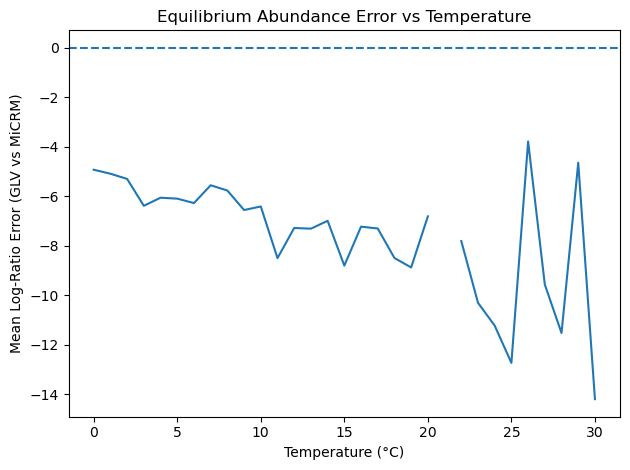

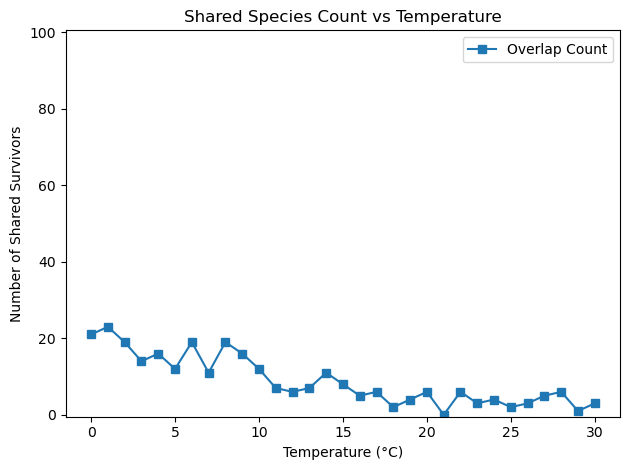

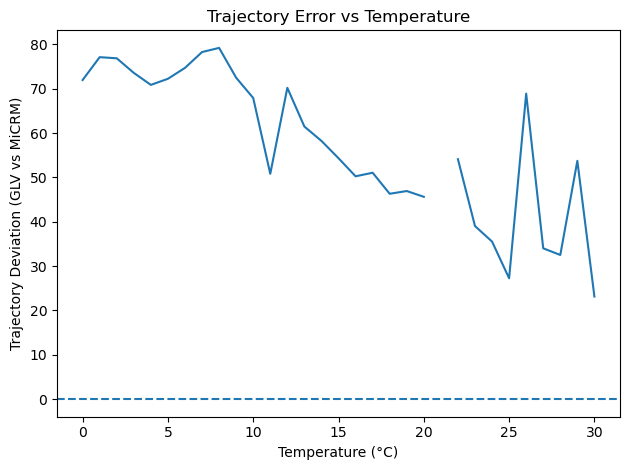

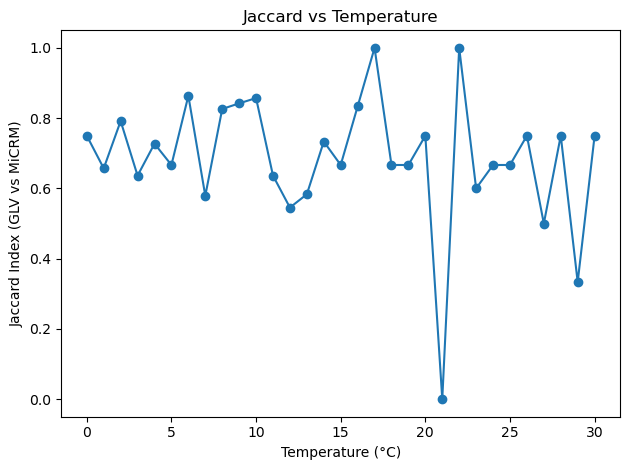

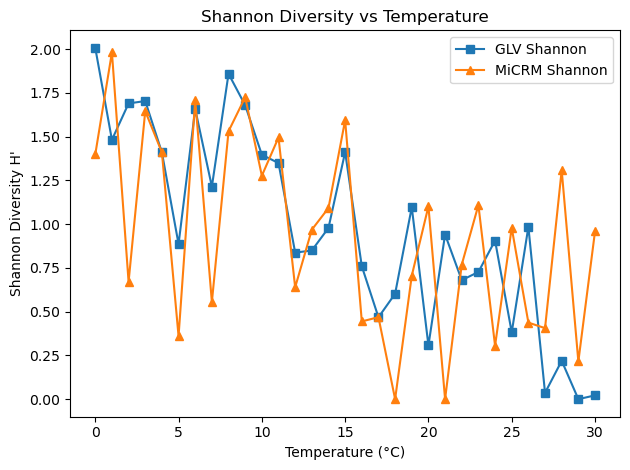

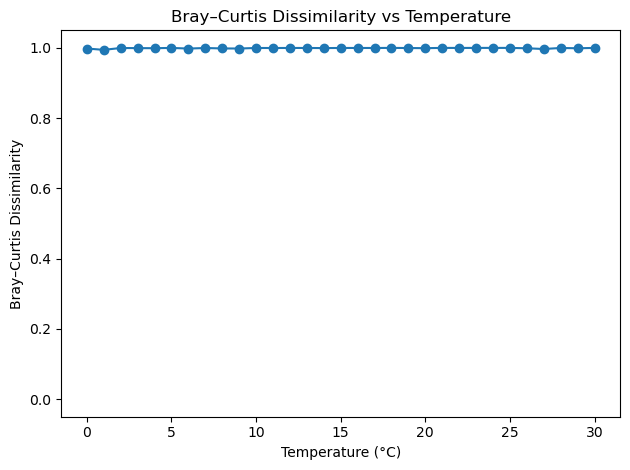

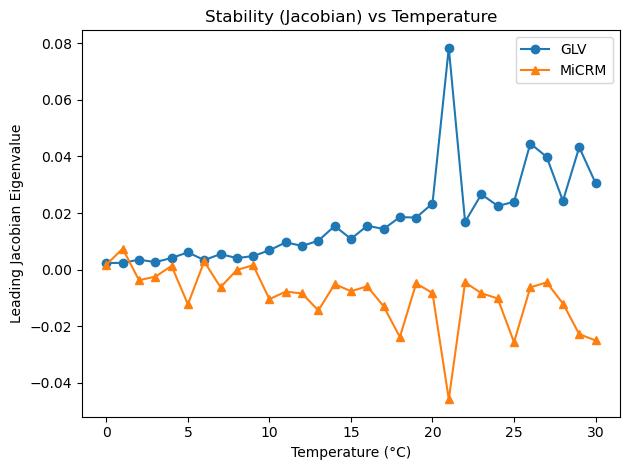

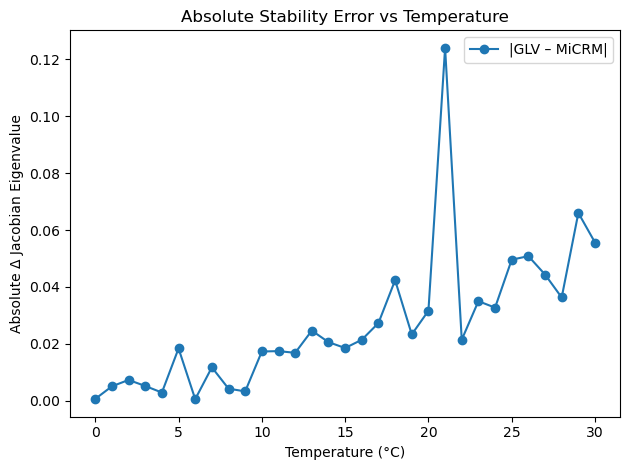

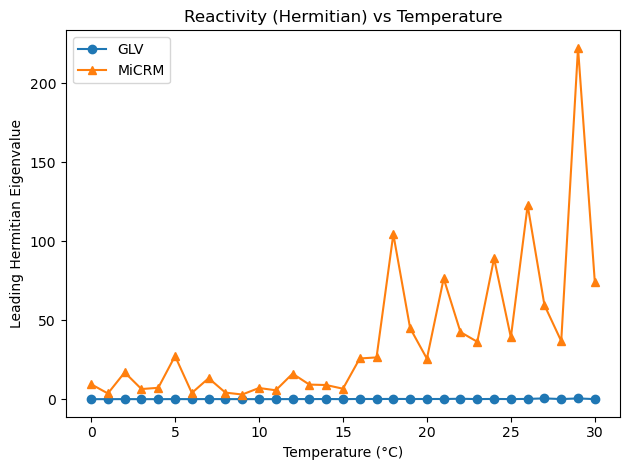

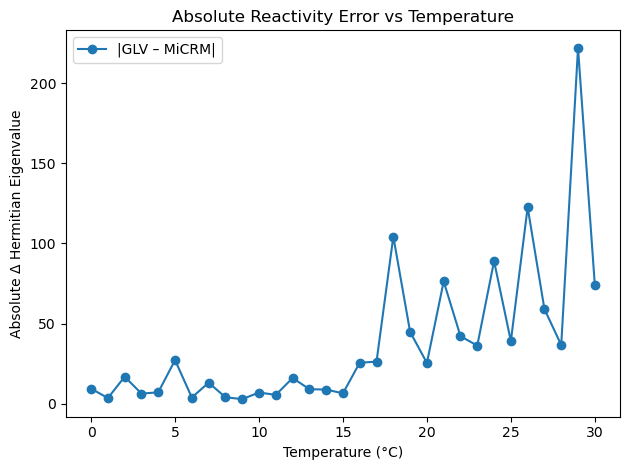

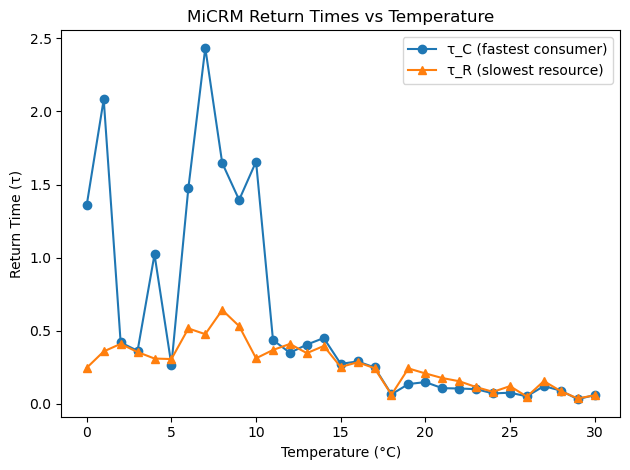

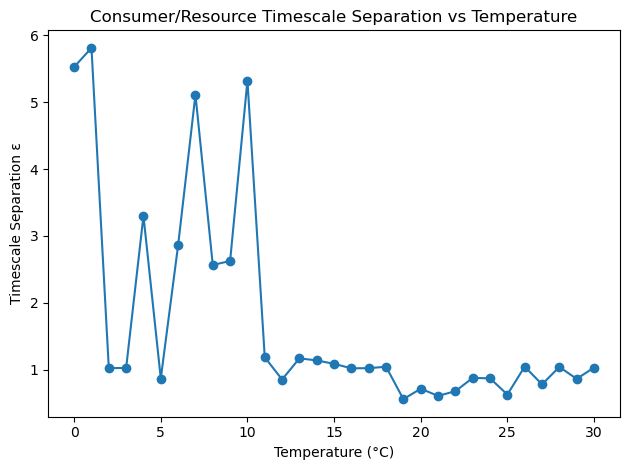

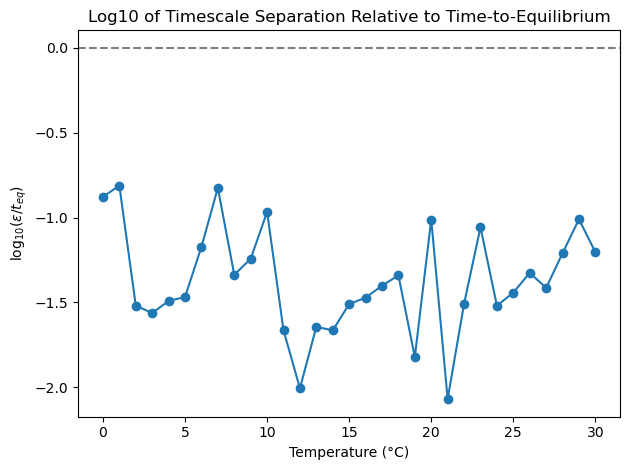

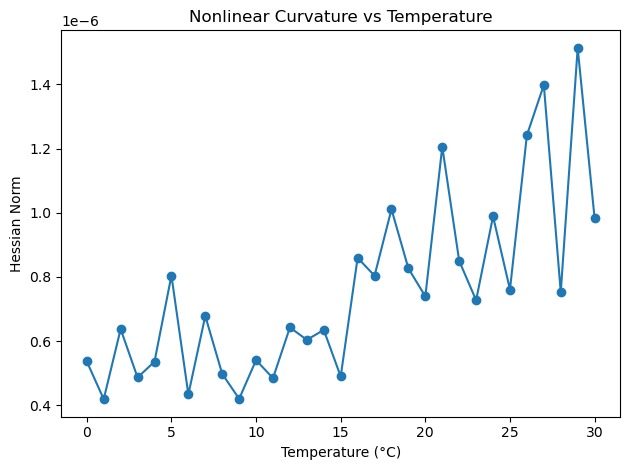

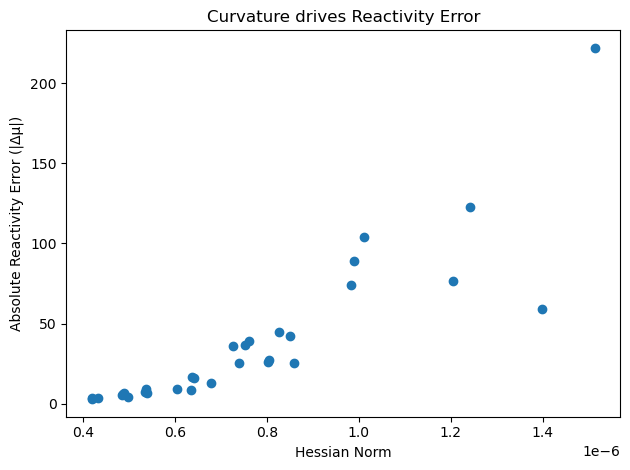

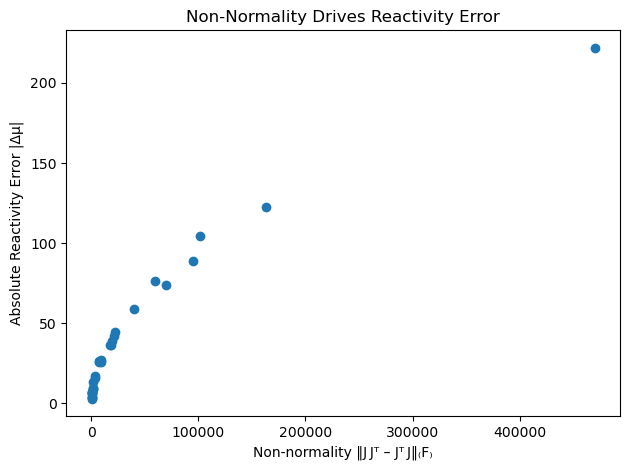

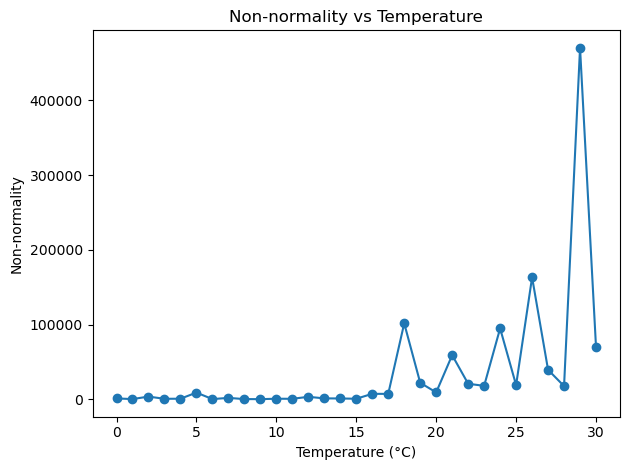

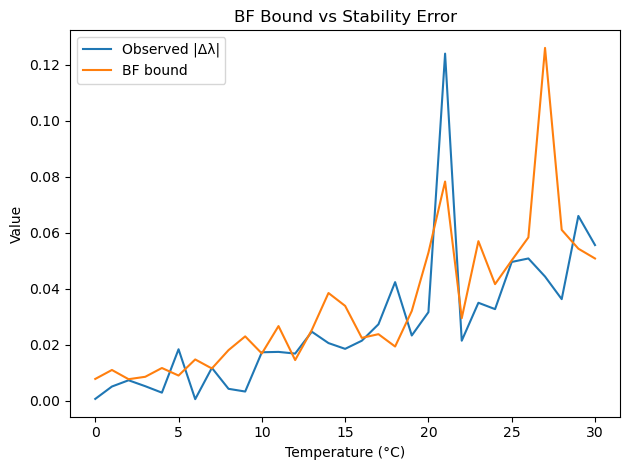

In [95]:
############################# PRODUCING ACTUAL SIMULATION GRAPHS #############################

import numpy as np
from numpy.random import default_rng
from scipy.integrate import solve_ivp
from numpy import linspace 
import matplotlib.pyplot as plt

"""
want to first generate parameters for a particular randomly-assembled community
and then simulate 31 different temperatures for this same community (both MiCRM and EGLV graphs for each temperature) 
compare how temperature affects the deviation between MiCRM and EGLV graphs
"""


rng = default_rng(111)

N = 100
M = 50
L = np.full(N, 0.3) # leakage (this is not temp dependent, as per original MiCRM)

x0 = np.concatenate([np.full(N, 0.1), np.full(M, 1)]) # initial conditions for consumers and resources

# Temperature‐dependence parameters
num_temps = 31 # number of temperatures
rho_t = np.array([0.0, 0.0])   # minimal trade‐off
Tr = 273.15 + 10 # reference temperature (10 °C)
Ed = 3.5 



####### TEST OUT DIFFERENT TEMPERATURES #######


structural = generate_params(
    N, M,
    f_u=def_u,      # relative preferences only
    f_m=def_m,      # placeholder
    f_rho=def_rho,
    f_omega=def_omega,
    f_l=def_l,
    # *no* T, Tr, Ed, rho_t here
    L=L,
    T=273.15,   # dummy (This satisfies temp_trait’s requirement that kw contain T, rho_t, Tr, Ed) 
    # since we are using the default def_u and def_m here, they ignore kw, so any T will work 
    # this whole thing will just provide relative preferences (u) and a constant m=1    
    rho_t=rho_t,  # dummy
    Tr=Tr,        # dummy
    Ed=Ed         # dummy
)

# the 'structural' parameters are static and don't change with temperature
# e.g. the def_u only generates relative preferences, not absolute ones
# however the uptake rate (u) will change with temperature. the relative preferences won't. 
# other things like rho and omega also don't change with temperature



temp_vals = linspace(273.15, 273.15 + 30, num_temps) # 31 temperatures from 0 to 30 degrees C

results = [] # store results for each temperature. it is a list of dictionaries. each temp would produce its own dictionary. 

for T in temp_vals:

    # temp-dependent scalars

    temp_p, B, E, Tp = temp_trait(N, {
        'T': T, 'Tr': Tr, 'Ed': Ed, 'rho_t': rho_t, 'L': L
    })
    temp_p_u = temp_p[:,0]
    temp_p_m = temp_p[:,1]

    # full parameter dictionary for this temp

    pT = {
        **structural,            # brings in u_pref, l, B, E, Tp, L, N, M, etc.
        'u': structural['u'] * temp_p_u[:,None],  # absolute uptake rates. the preference matrix from structural['u'] is multiplied (scaled) by the temperature-dependent uptake rates
        'm': temp_p_m,                            # mortality rates. the preference matrix from structural['m'] is multiplied (scaled) by the temperature-dependent mortality rates
        'lambda': np.sum(structural['l'], axis=2),
        'T': T
    }   
    

    # set up integration range

    t_max_micrm = 300
    t_max_glv   = 300

    t_eval_micrm = np.linspace(0, t_max_micrm, 300)
    t_eval_glv   = np.linspace(0, t_max_glv,   300)


    # solve MiCRM at this temperature (for equilibrium values, ignoring trajectory) 
    

    sol = solve_ivp(
                lambda t, y: MiCRM_dxx_numba_wrapper(t, y, pT),
                t_span=(0, t_max_micrm), 
                y0=x0,
                method='LSODA', 
                rtol=1e-4, atol=1e-7)

    
    # solve EGLV at this temperature (for equilibrium values, ignoring trajectory) 
    
    p_lv = eff_LV_params(pT, sol, verbose=False)

    sol_lv = solve_ivp(
        lambda t, y: LV_dx(y, t, p_lv),
        t_span=(0, t_max_glv), 
        y0=sol.y[:N, 0],
        method='LSODA',
        rtol=1e-4, atol=1e-7       
        )
    

    # solve again but with more timepoints (for trajectory deviation analysis) 

    """
    This should make the runtime faster. 
    for equilibrium-related analysis (e.g. Jacobian, equilibrium abundance errors), we only care about the final value 
    so we can separate out the trajectory analysis below, which requires finer timepoints 
    this way, we don't need to compute the trajectory and use it for every single analysis 
    """

    sol_traj = solve_ivp(
        lambda t,y: MiCRM_dxx_numba_wrapper(t, y, pT),
        t_span=(0,300), y0=x0,
        method='LSODA', rtol=1e-4, atol=1e-7,
        t_eval=np.linspace(0,300,300)
        )
    sol_traj_lv = solve_ivp(
        lambda t,y: LV_dx(y, t, p_lv),
        t_span=(0,300), y0=sol_traj.y[:N,0],
        method='LSODA', rtol=1e-4, atol=1e-7,
        t_eval=sol_traj.t
        )
    Err_traj = integrate_err(*err_time_series(sol_traj.t,
                                              sol_traj_lv.y[:N],
                                              sol_traj.y[:N])[0:2])

    ##### deviation calculations #####

    # first collect the equilibrium values for MiCRM and GLV (this is the last value in time series, t1)
    times      = sol.t
    C_MiCRM_eq = sol.y[:N, -1] # equilibrium consumer biomass
    C_LV_eq = sol_lv.y[:N, -1] # equilibrium consumer biomass
    
       
    # equilibrium abundance deviation 
    ErrEqAb, overlap = err_eq_and_overlap(C_LV_eq, C_MiCRM_eq)

      # diversity deviation
    jaccard = jaccard_index(C_LV_eq, C_MiCRM_eq, thresh=1e-6)
    sh_LV = shannon(C_LV_eq)
    sh_Mi = shannon(C_MiCRM_eq)
    bc = bray_curtis_dissimilarity(C_LV_eq, C_MiCRM_eq)

    # stability (Jacobian) and reactivity (Hermitian) 
    J_glv   = eff_LV_jac(p_lv, sol)
    stab_glv  = leading_eigenvalue(J_glv)
    react_glv = leading_hermitian_eigenvalue(J_glv)

    J_micrm   = MiCRM_jac(pT, sol)
    stab_mic  = leading_eigenvalue(J_micrm)
    react_mic = leading_hermitian_eigenvalue(J_micrm)

    # timescale separation (using full method, not simplified)
    tau_C, tau_R, epsilon = timescale_separation_full(J_micrm, N)
    j_eq = estimate_teq(times, sol, sol_lv, tol=1e-6, window=5) # find equilibrium time 
    t_eq   = times[j_eq] # convert to actual time 

    # Hessian norm at consumer equilibrium
    N, M   = pT['N'], pT['M']
    u      = pT['u']
    lam    = pT['lambda']
    rho    = pT['rho']
    omega  = pT['omega']
    l      = pT['l']
    m_vec  = pT['m']

    # Then compute Hessian norm in one line:
    hess_norm = compute_hessian_norm_nb(
        C_MiCRM_eq, N, M,
        u, lam, rho, omega, l, m_vec,
        eps=1e-6
    )


    # non‐normality
    comm      = J_micrm @ J_micrm.T - J_micrm.T @ J_micrm
    nnorm     = np.linalg.norm(comm, ord='fro')

    # bauer fike bound 
    BF_bound = bauer_fike_bound(J_micrm, p_lv, C_MiCRM_eq, C_LV_eq, threshold=1e-6)
 

         
    ##### store results as a dictionary ##### 

    results.append(dict(T=T, 
                        sol=sol, 
                        sol_lv=sol_lv, 
                        ErrEqAb=ErrEqAb, 
                        overlap=overlap,
                        ErrTraj=Err_traj,
                        jaccard=jaccard,
                        sh_LV=sh_LV,
                        sh_Mi=sh_Mi,
                        bray_curtis=bc,
                        stab_glv=stab_glv,
                        stab_mic=stab_mic,
                        react_glv=react_glv,
                        react_mic=react_mic,
                        tau_C=tau_C,
                        tau_R=tau_R,
                        epsilon=epsilon,
                        t_eq=t_eq,
                        hessian_norm=hess_norm,
                        nnorm=nnorm,
                        BF_bound=BF_bound
                        ))

# analyse results for equilibrium abundance

# extract values for plotting 
temps_C = temp_vals - 273.15 # Convert temperature array from K to °C
errs     = [r['ErrEqAb'] for r in results]
overlaps = [r['overlap']  for r in results]
errtraj = [r['ErrTraj']  for r in results]
jaccards = [r['jaccard'] for r in results]
sh_lvs   = [r['sh_LV']   for r in results]
sh_mis   = [r['sh_Mi']   for r in results]
bcs = [r['bray_curtis']   for r in results]
stabs_glv  = [r['stab_glv']  for r in results]
stabs_mic  = [r['stab_mic']  for r in results]
reacts_glv = [r['react_glv'] for r in results]
reacts_mic = [r['react_mic'] for r in results]
abs_diff_stab  = np.abs(np.array(stabs_glv ) - np.array(stabs_mic )) # absolute differences 
abs_diff_react = np.abs(np.array(reacts_glv) - np.array(reacts_mic)) # absolute differences 
taus_C      = [r['tau_C']    for r in results]
taus_R      = [r['tau_R']    for r in results]
epsilons    = [r['epsilon']  for r in results]
t_eqs     = [r['t_eq']    for r in results]
hessians   = [r['hessian_norm'] for r in results]
nnorms        = [r['nnorm']         for r in results]
BF_bounds     = [r['BF_bound']     for r in results]

######################################### PLOTTING #############################################


import matplotlib.pyplot as plt

# plot abundance deviation at equilibrium 
plt.figure()
plt.plot(temps_C, errs)
plt.xlabel("Temperature (°C)")
plt.ylabel("Mean Log-Ratio Error (GLV vs MiCRM)")
plt.title("Equilibrium Abundance Error vs Temperature")
plt.axhline(0, linestyle='--')   # horizontal zero line
plt.tight_layout()
plt.show()

# plot number of species overlap for GLV/MiCRM at equilibrium (accuracy in terms of diversity predictions)
plt.figure()
plt.plot(temps_C, overlaps, marker='s', label='Overlap Count')
plt.xlabel("Temperature (°C)")
plt.ylabel("Number of Shared Survivors")
plt.title("Shared Species Count vs Temperature")
plt.ylim(-0.5, N + 0.5)  # N is total species, e.g. 7
plt.legend()
plt.tight_layout()
plt.show()

# plot trajectory deviation 
plt.figure()
plt.plot(temps_C, errtraj)
plt.xlabel("Temperature (°C)")
plt.ylabel("Trajectory Deviation (GLV vs MiCRM)")
plt.title("Trajectory Error vs Temperature")
plt.axhline(0, linestyle='--')   # horizontal zero line
plt.tight_layout()
plt.show()

# Temperature vs Jaccard
plt.figure()
plt.plot(temps_C, jaccards, marker='o')
plt.xlabel("Temperature (°C)")
plt.ylabel("Jaccard Index (GLV vs MiCRM)")
plt.title("Jaccard vs Temperature")
plt.ylim(-0.05, 1.05)
plt.tight_layout()
plt.show()

# Temperature vs Shannon diversity (two lines)
plt.figure()
plt.plot(temps_C, sh_lvs, marker='s', label="GLV Shannon")
plt.plot(temps_C, sh_mis, marker='^', label="MiCRM Shannon")
plt.xlabel("Temperature (°C)")
plt.ylabel("Shannon Diversity H'")
plt.title("Shannon Diversity vs Temperature")
plt.legend()
plt.tight_layout()
plt.show()

# Bray-Curtis (for community composition - incorporating both diversity + abundance)

plt.figure()
plt.plot(temps_C, bcs, marker='o')
plt.xlabel("Temperature (°C)")
plt.ylabel("Bray–Curtis Dissimilarity")
plt.title("Bray–Curtis Dissimilarity vs Temperature")
plt.ylim(-0.05, 1.05)
plt.tight_layout()
plt.show()

# Temperature vs leading Jacobian eigenvalue
plt.figure()
plt.plot(temps_C, stabs_glv, marker='o', label='GLV')
plt.plot(temps_C, stabs_mic, marker='^', label='MiCRM')
plt.xlabel("Temperature (°C)")
plt.ylabel("Leading Jacobian Eigenvalue")
plt.title("Stability (Jacobian) vs Temperature")
plt.legend()
plt.tight_layout()
plt.show()

# Temperature vs |Δ leading Jacobian eigenvalue|    (absolute difference) 
plt.figure()
plt.plot(temps_C, abs_diff_stab, marker='o', label='|GLV – MiCRM|')
plt.xlabel("Temperature (°C)")
plt.ylabel("Absolute Δ Jacobian Eigenvalue")
plt.title("Absolute Stability Error vs Temperature")
plt.legend()
plt.tight_layout()
plt.show()

# Temperature vs leading Hermitian‐part eigenvalue
plt.figure()
plt.plot(temps_C, reacts_glv, marker='o', label='GLV')
plt.plot(temps_C, reacts_mic, marker='^', label='MiCRM')
plt.xlabel("Temperature (°C)")
plt.ylabel("Leading Hermitian Eigenvalue")
plt.title("Reactivity (Hermitian) vs Temperature")
plt.legend()
plt.tight_layout()
plt.show()

# Temperature vs |Δ leading Hermitian eigenvalue|   (absolute difference)
plt.figure()
plt.plot(temps_C, abs_diff_react, marker='o', label='|GLV – MiCRM|')
plt.xlabel("Temperature (°C)")
plt.ylabel("Absolute Δ Hermitian Eigenvalue")
plt.title("Absolute Reactivity Error vs Temperature")
plt.legend()
plt.tight_layout()
plt.show()

# Temperature vs consumer & resource timescales
plt.figure()
plt.plot(temps_C, taus_C, marker='o', label='τ_C (fastest consumer)')
plt.plot(temps_C, taus_R, marker='^', label='τ_R (slowest resource)')
plt.xlabel("Temperature (°C)")
plt.ylabel("Return Time (τ)")
plt.title("MiCRM Return Times vs Temperature")
plt.legend()
plt.tight_layout()
plt.show()

# Temperature vs timescale‐separation ε = τ_C / τ_R
plt.figure()
plt.plot(temps_C, epsilons, marker='o')
plt.xlabel("Temperature (°C)")
plt.ylabel("Timescale Separation ε")
plt.title("Consumer/Resource Timescale Separation vs Temperature")
plt.tight_layout()
plt.show()

# timescale separation, log10(epsilon / t_eq) vs Temperature

ratio = np.log10(np.array(epsilons) / np.array(t_eqs))
plt.figure()
plt.plot(temps_C, ratio, marker='o')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Temperature (°C)")
plt.ylabel(r"$\log_{10}(\varepsilon / t_{eq})$")
plt.title("Log10 of Timescale Separation Relative to Time-to-Equilibrium")
plt.tight_layout()
plt.show()


"""
Investigating what is causing differences in reactivity / stability 
"""

# Curvature vs Temperature
plt.figure()
plt.plot(temps_C, hessians, marker='o')
plt.xlabel("Temperature (°C)")
plt.ylabel("Hessian Norm")
plt.title("Nonlinear Curvature vs Temperature")
plt.tight_layout()
plt.show()

# Reactivity‐error vs Curvature
plt.figure()
plt.scatter(hessians, abs_diff_react)
plt.xlabel("Hessian Norm")
plt.ylabel("Absolute Reactivity Error (|Δμ|)")
plt.title("Curvature drives Reactivity Error")
plt.tight_layout()
plt.show()

# non-normality vs reactivity error
plt.figure()
plt.scatter(nnorms, abs_diff_react)
plt.xlabel("Non-normality ‖J Jᵀ – Jᵀ J‖₍F₎")
plt.ylabel("Absolute Reactivity Error |Δμ|")
plt.title("Non-Normality Drives Reactivity Error")
plt.tight_layout()
plt.show()

# non-normality vs temperature 
plt.figure()
plt.plot(temps_C, nnorms, marker='o')
plt.xlabel("Temperature (°C)")
plt.ylabel("Non-normality")
plt.title("Non-normality vs Temperature")
plt.tight_layout()
plt.show()

# bauer fike (why stability changes with temp)
plt.figure()
plt.plot(temps_C, abs_diff_stab, label='Observed |Δλ|')
plt.plot(temps_C, BF_bounds,   label='BF bound')
plt.legend()
plt.title("BF Bound vs Stability Error")
plt.xlabel("Temperature (°C)")
plt.ylabel("Value")
plt.tight_layout()
plt.show()



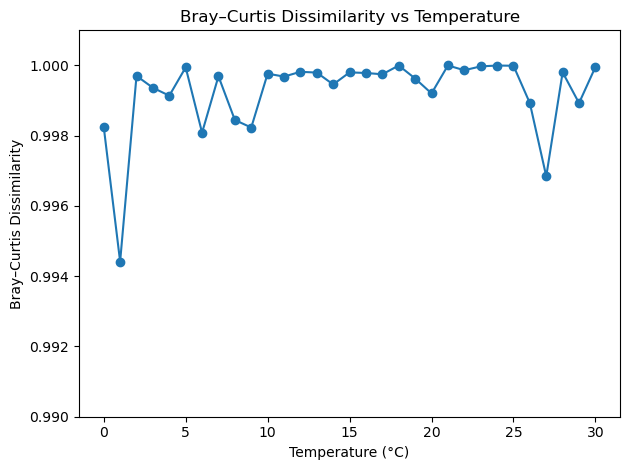

In [ ]:
# quick re-run of bray-curtis, adjusting the y-axis 

plt.figure()
plt.plot(temps_C, bcs, marker='o')
plt.xlabel("Temperature (°C)")
plt.ylabel("Bray–Curtis Dissimilarity")
plt.title("Bray–Curtis Dissimilarity vs Temperature")
plt.ylim(0.99, 1.001)
plt.tight_layout()
plt.show()

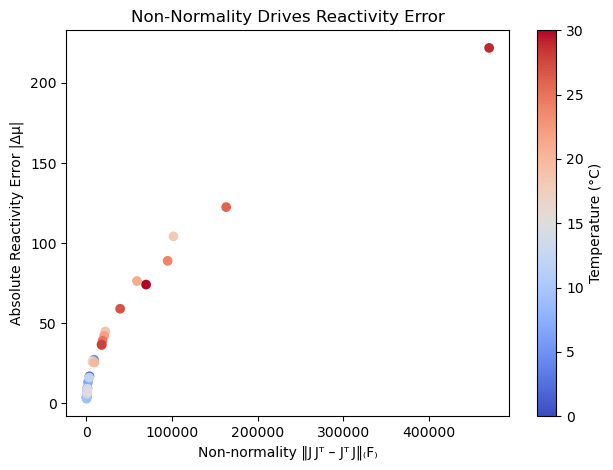

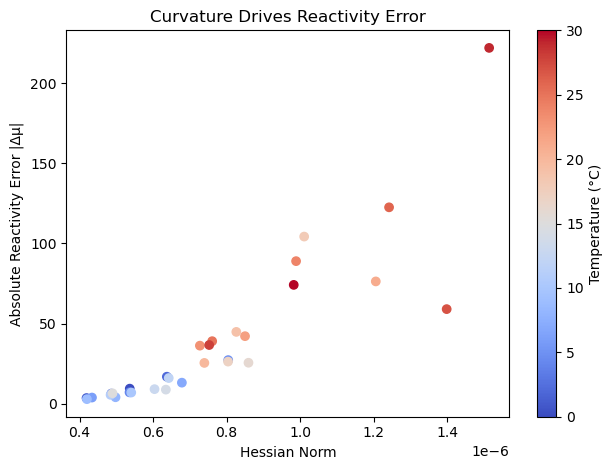

In [99]:
# adding temperature gradients to some previous plots for better visualisation 

plt.figure()
scatter = plt.scatter(nnorms, abs_diff_react, c=temps_C, cmap='coolwarm')  # temps = array of temperatures
plt.xlabel("Non-normality ‖J Jᵀ – Jᵀ J‖₍F₎")
plt.ylabel("Absolute Reactivity Error |Δμ|")
plt.title("Non-Normality Drives Reactivity Error")
cbar = plt.colorbar(scatter)
cbar.set_label("Temperature (°C)")
plt.tight_layout()
plt.show()


plt.figure()
scatter = plt.scatter(hessians, abs_diff_react, c=temps_C, cmap='coolwarm')
plt.xlabel("Hessian Norm")
plt.ylabel("Absolute Reactivity Error |Δμ|")
plt.title("Curvature Drives Reactivity Error")
cbar = plt.colorbar(scatter)
cbar.set_label("Temperature (°C)")
plt.tight_layout()
plt.show()


RUNTIME UPDATE: 20 minutes for N = 100 and M = 50 (but only single community) 